In [1]:
# basic stuff 
from scipy import stats, signal, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# from google.colab import files
import os
import sklearn
import time
import json
import math
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import subprocess
from sklearn.preprocessing import StandardScaler
import seaborn as sn

# torch stuff
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch.nn.functional as F

# !pip install mat73
# import mat73

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/')
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/xds_python/')
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/custom_functions/')

from xds import lab_data
import joint_angles

In [115]:
import importlib
import data_loading
import train_test
import r2_pr2
import models
import visualization

importlib.reload(visualization)

<module 'visualization' from '/content/drive/MyDrive/Miller_Lab/FIU/custom_functions/visualization.py'>

# Step 2: Preprocessing XDS File

Data is loaded with the xds lab_data module. You can ignore 20220309 

In [6]:
mat_20210712_xds = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/combined_opensim_neural/','20210712_Pop_FR_01.mat')
mat_20211105_xds = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/combined_opensim_neural/','20211105_Pop_FR_001.mat')
mat_20210814_xds = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/combined_opensim_neural/','Pop_20210814_FR_001.mat')
mat_20210710_xds = lab_data('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/combined_opensim_neural/','Pop_20210710_FR_001.mat')

xds_list = [mat_20210712_xds, mat_20211105_xds, mat_20210814_xds, mat_20210710_xds]

The second and third joint angles must be converted from radians to degrees.

In [7]:
# convert 2nd and 3rd electrodes to degrees
mat_20210712_xds.joint_angles[:,1]*=180/np.pi
mat_20210712_xds.joint_angles[:,2]*=180/np.pi
# convert 2nd and 3rd electrodes to degrees
mat_20211105_xds.joint_angles[:,1]*=180/np.pi
mat_20211105_xds.joint_angles[:,2]*=180/np.pi
# convert 2nd and 3rd electrodes to degrees
mat_20210814_xds.joint_angles[:,1]*=180/np.pi
mat_20210814_xds.joint_angles[:,2]*=180/np.pi
# convert 2nd and 3rd electrodes to degrees
mat_20210710_xds.joint_angles[:,1]*=180/np.pi
mat_20210710_xds.joint_angles[:,2]*=180/np.pi

Check shapes of joint angle and neural spike data.

In [8]:
for xds_file in xds_list:
    print(xds_file.joint_angles.shape, xds_file.spike_counts.shape)

(35970, 24) (1199008, 142)
(35941, 24) (1199008, 113)
(53941, 24) (1799012, 145)
(53941, 24) (1799012, 153)


In [9]:
for data in xds_list:
    print('Session Duration: {}, Num Neural Instances: {}'.format(data.get_meta()['duration'], data.spike_counts.shape))

Session Duration: 1200.0040000000001, Num Neural Instances: (1199008, 142)
Session Duration: 1200.0040000000001, Num Neural Instances: (1199008, 113)
Session Duration: 1800.0095, Num Neural Instances: (1799012, 145)
Session Duration: 1800.0095, Num Neural Instances: (1799012, 153)


Neural spikes, originally binned at 1000Hz during the XDS conversion, must be binned to match the joint angle data (30Hz) using the update_bin_data method. 
Spikes are then smoothed using the smooth_binned_spikes method using a gaussian filter of width (2 x bin_size) in accordance with standard practice. Resulting binned and smoothed spikes are converted to firing rates by dividing by bin_size.

In [10]:
for xds_file in xds_list:
    bin_size = 1/30
    print('Shape before binning+smoothing is: {}'.format(xds_file.spike_counts.shape))
    xds_file.update_bin_data(bin_size)                                                    #bin
    xds_file.smooth_binned_spikes(bin_size, 'gaussian', bin_size*2)                       #smooth
    print('Shape after binning+smoothing is: {}'.format(xds_file.spike_counts.shape))
    xds_file.spike_counts = xds_file.spike_counts/bin_size                                #convert to firing rates

Shape before binning+smoothing is: (1199008, 142)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (35971, 142)
Shape before binning+smoothing is: (1199008, 113)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (35971, 113)
Shape before binning+smoothing is: (1799012, 145)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (53971, 145)
Shape before binning+smoothing is: (1799012, 153)
The new bin size is 0.0333 s
The spike counts have been smoothed.
Shape after binning+smoothing is: (53971, 153)


Check the shapes of the data again. As you can see, the neural data is longer than the joint angle data. This is due to an alignment issue addressed in the XDS code.

In [11]:
for xds_file in xds_list:
    print(xds_file.joint_angles.shape, xds_file.spike_counts.shape)

(35970, 24) (35971, 142)
(35941, 24) (35971, 113)
(53941, 24) (53971, 145)
(53941, 24) (53971, 153)


The end of the neural array must be trimmed in order to match the length of the joint angle data. Inputs and targets are stored in dictionaries to keep track. Note that you can convert joint angles into joint velocities using the get_joint_velocities function from the joint_angles module if you prefer to use velocities (or concantenated angles + velocities) as input.

In [12]:
# inputs
joint_angles_dict = {'20210712':mat_20210712_xds.joint_angles, 
                     '20211105':mat_20211105_xds.joint_angles, 
                     '20210814':mat_20210814_xds.joint_angles, 
                     '20210710':mat_20210710_xds.joint_angles}

velocities_dict = {'20210712':joint_angles.get_joint_velocities(mat_20210712_xds.joint_angles), 
                     '20211105':joint_angles.get_joint_velocities(mat_20211105_xds.joint_angles),
                     '20210814':joint_angles.get_joint_velocities(mat_20210814_xds.joint_angles), 
                     '20210710':joint_angles.get_joint_velocities(mat_20210710_xds.joint_angles)}

angles_and_velocities_dict = {'20210712':np.hstack((joint_angles_dict['20210712'], velocities_dict['20210712'])),
                              '20211105':np.hstack((joint_angles_dict['20211105'], velocities_dict['20211105'])),
                              '20210814':np.hstack((joint_angles_dict['20210814'], velocities_dict['20210814'])),
                              '20210710':np.hstack((joint_angles_dict['20210710'], velocities_dict['20210710']))}

# targets
# trim frames at the end to align neural with kinematic data
firing_rates_dict = {'20210712':mat_20210712_xds.spike_counts[:-1,:],
                    '20211105':mat_20211105_xds.spike_counts[:-30,:],
                    '20210814':mat_20210814_xds.spike_counts[:-30,:],
                    '20210710':mat_20210710_xds.spike_counts[:-30,:]
                    } 

Now inputs and targets have the same number of instances.

In [14]:
for date in joint_angles_dict.keys():
    print(date, joint_angles_dict[date].shape, firing_rates_dict[date].shape)

20210712 (35970, 24) (35970, 142)
20211105 (35941, 24) (35941, 113)
20210814 (53941, 24) (53941, 145)
20210710 (53941, 24) (53941, 153)


For plotting purposes, I manually examined the videos to find a continguous 20 second interval where the monkey is doing something interesting. The reason I do this is because I shuffle the datasets before saving them and randomly assign instances to training and testing sets. Doing this allows me to separate contiguous segments of data that can be tested on and visualized - namely to compare true target behavior vs predictions. I store those ranges and results in dictionaries called "good_frates_dict", "good_inputs_dict", and "good_frates_range_dict".
In order to make datasets in the next step, store each of the joint angles in dictionaries so they can easily be accessed by each of the dataset classes.

In [15]:
dates_list = ['20211108', '20210830', '20210921', '20211009']
good_inputs_dict = {'20210712':mat_20210712_xds.joint_angles[540:1140],
                    '20211105':mat_20211105_xds.joint_angles[3000:3600],
                    '20210710':mat_20210710_xds.joint_angles[4650:5250],
                    '20210814':mat_20210814_xds.joint_angles[4500:5100],
                    }
good_velocities_dict = {'20210712':joint_angles.get_joint_velocities(mat_20210712_xds.joint_angles[540:1140]),
                    '20211105':joint_angles.get_joint_velocities(mat_20211105_xds.joint_angles[3000:3600]),
                    '20210710':joint_angles.get_joint_velocities(mat_20210710_xds.joint_angles[4650:5250]),
                    '20210814':joint_angles.get_joint_velocities(mat_20210814_xds.joint_angles[4500:5100]),
                    }

good_frates_dict = {'20210712':firing_rates_dict['20210712'][540:1140],\
                    '20211105':firing_rates_dict['20211105'][3000:3600],\
                    '20210814':firing_rates_dict['20210814'][4500:5100],\
                    '20210710':firing_rates_dict['20210710'][4650:5250],
                    }
good_frates_range_dict = {'20210712':(540,1140),
                          '20211105':(3000,3600),
                          '20210814':(4500,5100),
                          '20210710':(4650,5250),}

To artificially create more datasets, I also randomly split the datasets by elecrode and store them in dictionaries. This is optional.

In [16]:
#split each dataset into 3 datasets - randomly split by column (electrode)
firing_rates_dict_split = {}
for date in firing_rates_dict.keys():
    num_neurons = firing_rates_dict[date].shape[1]
    splt = int(num_neurons/3)
    shuffled_neurons = np.arange(num_neurons)
    np.random.shuffle(shuffled_neurons) #shuffle neurons in place
    split1 = shuffled_neurons[:splt]
    split2 = shuffled_neurons[splt:2*splt]
    split3 = shuffled_neurons[2*splt:]
    firing_rates_dict_split[date] = {}
    firing_rates_dict_split[date][0] = firing_rates_dict[date][:,split1]
    firing_rates_dict_split[date][1] = firing_rates_dict[date][:,split2]
    firing_rates_dict_split[date][2] = firing_rates_dict[date][:,split3]

In [17]:
for date in firing_rates_dict_split.keys():
    for splt in firing_rates_dict_split[date].keys():
        print(date, splt, firing_rates_dict_split[date][splt].shape)

20210712 0 (35970, 47)
20210712 1 (35970, 47)
20210712 2 (35970, 48)
20211105 0 (35941, 37)
20211105 1 (35941, 37)
20211105 2 (35941, 39)
20210814 0 (53941, 48)
20210814 1 (53941, 48)
20210814 2 (53941, 49)
20210710 0 (53941, 51)
20210710 1 (53941, 51)
20210710 2 (53941, 51)


# Step 3: Creating and saving datasets and dataloaders

There are two dataset classes available: MLPDataset and TCNDataset.

The MLPDataset class is used to make datasets for MLPs. Each instance in this dataset is a tuple containing input, output, and frame number. Each input/output pair corresponds to a single frame in the video.
The TCNDataset class is used to make datasets for TCNs. Each instance in this dataset is a tuple containing input, output, and frame numbers. Each input/output pair corresponds to N frames in the video, where N can be specified in the class instantiation (default = 100). 

You can create and save datasets with the create_and_save_datasets function in the data_loading.py script. This function has several inputs, most of which are used simply to make subfolders for different types dataset (e.g. fully restrained vs semirestrained, split by neuron vs non split). This code needs to be changed in order to save your datasets in the correct directories. Note that it automatically saves a train, test, and full version of the dataset. The full version of the dataset is saved for two main reasons: 1) important attributes regarding that dataset (e.g. date, target size, input type, etc.) are lost when making train/test subsets. The full version of the dataset is used in many other functions to keep track of these attributes. 2) While I never did this, the full dataset can be used to make other training/testing datasets for N-fold cross-validation. Note that the full version of the dataset does NOT retain the 20 second contiguous intervals mentioned above.

MLP Dataset

In [18]:
inp_types = ['Joint Angles']
for date in joint_angles_dict.keys():
    print(date)
    for inp_type in inp_types:
        for split_num in [0,1,2]:
            dataset = data_loading.MLPDataset(date, inp_type, joint_angles_dict, firing_rates_dict_split, good_frates_range_dict[date], 
                                              split_neurons = True, split_num = split_num, shuffle = True)
            data_loading.create_and_save_datasets(dataset, tcnn = False, split_neurons = True, split_num = split_num, restraint_type = 'fullyrestrained')

20210712
20211105
20210814
20210710


TCN Dataset

In [20]:
inp_types = ['Joint Angles']
for date in joint_angles_dict.keys():
    print(date)
    for inp_type in inp_types:
        for split_num in [0,1,2]:
            dataset = data_loading.TCNDataset(date, inp_type, joint_angles_dict, firing_rates_dict_split, good_frates_range_dict[date], 
                                              split_neurons = True, split_num = split_num, shuffle = True)
            data_loading.create_and_save_datasets(dataset, tcnn = True, split_neurons = True, split_num = split_num, restraint_type = 'fullyrestrained')

20210712
20211105
20210814
20210710


Once the datasets are saved in the appropriate location, you can load all your datasets into a single dictionary using load_datasets. You can then convert those into dataloaders using get_loaders.

In [21]:
base_dir = '/content/drive/My Drive/Miller_Lab/FIU/PopFRData/tutorial/processed_shuffled_opensim_datasets_splitneurons/fullyrestrained/'
mlp_dataset_dict = data_loading.load_datasets(base_dir, split_neurons = True)
mlp_loader_dict = data_loading.get_loaders(mlp_dataset_dict, 32, split_neurons = True)

In [22]:
base_dir = '/content/drive/My Drive/Miller_Lab/FIU/PopFRData/tutorial/tcnn_processed_shuffled_opensim_datasets_splitneurons/instance_length_100/fullyrestrained/'
tcn_dataset_dict = data_loading.load_datasets(base_dir, split_neurons = True)
tcn_loader_dict = data_loading.get_loaders(tcn_dataset_dict, 32, split_neurons = True)

In [23]:
for date in mlp_dataset_dict.keys():
    for input_type in mlp_dataset_dict[date].keys():
        for split_num in mlp_dataset_dict[date][input_type].keys():
            print('Date: {}, Input Type: {}, Split Number: {}, Num Instances: {}, Input Shape: {}, Target Shape: {}'\
                  .format(date, input_type, split_num,
                  len(mlp_dataset_dict[date][input_type][split_num]['Full']),
                  mlp_dataset_dict[date][input_type][split_num]['Full'][0][0].shape,
                  mlp_dataset_dict[date][input_type][split_num]['Full'][0][1].shape))

Date: 20210712, Input Type: Joint Angles, Split Number: 0, Num Instances: 35370, Input Shape: torch.Size([24]), Target Shape: torch.Size([47])
Date: 20210712, Input Type: Joint Angles, Split Number: 1, Num Instances: 35370, Input Shape: torch.Size([24]), Target Shape: torch.Size([47])
Date: 20210712, Input Type: Joint Angles, Split Number: 2, Num Instances: 35370, Input Shape: torch.Size([24]), Target Shape: torch.Size([48])
Date: 20211105, Input Type: Joint Angles, Split Number: 0, Num Instances: 35341, Input Shape: torch.Size([24]), Target Shape: torch.Size([37])
Date: 20211105, Input Type: Joint Angles, Split Number: 1, Num Instances: 35341, Input Shape: torch.Size([24]), Target Shape: torch.Size([37])
Date: 20211105, Input Type: Joint Angles, Split Number: 2, Num Instances: 35341, Input Shape: torch.Size([24]), Target Shape: torch.Size([39])
Date: 20210814, Input Type: Joint Angles, Split Number: 0, Num Instances: 53341, Input Shape: torch.Size([24]), Target Shape: torch.Size([48])

In [24]:
for date in tcn_dataset_dict.keys():
    for input_type in tcn_dataset_dict[date].keys():
        for split_num in tcn_dataset_dict[date][input_type].keys():
            print('Date: {}, Input Type: {}, Split Number: {}, Num Instances: {}, Input Shape: {}, Target Shape: {}'\
                  .format(date, input_type, split_num,
                  len(tcn_dataset_dict[date][input_type][split_num]['Full']),
                  tcn_dataset_dict[date][input_type][split_num]['Full'][0][0].shape,
                  tcn_dataset_dict[date][input_type][split_num]['Full'][0][1].shape))

Date: 20210712, Input Type: Joint Angles, Split Number: 0, Num Instances: 353, Input Shape: torch.Size([24, 100]), Target Shape: torch.Size([100, 47])
Date: 20210712, Input Type: Joint Angles, Split Number: 1, Num Instances: 353, Input Shape: torch.Size([24, 100]), Target Shape: torch.Size([100, 47])
Date: 20210712, Input Type: Joint Angles, Split Number: 2, Num Instances: 353, Input Shape: torch.Size([24, 100]), Target Shape: torch.Size([100, 48])
Date: 20211105, Input Type: Joint Angles, Split Number: 0, Num Instances: 353, Input Shape: torch.Size([24, 100]), Target Shape: torch.Size([100, 37])
Date: 20211105, Input Type: Joint Angles, Split Number: 1, Num Instances: 353, Input Shape: torch.Size([24, 100]), Target Shape: torch.Size([100, 37])
Date: 20211105, Input Type: Joint Angles, Split Number: 2, Num Instances: 353, Input Shape: torch.Size([24, 100]), Target Shape: torch.Size([100, 39])
Date: 20210814, Input Type: Joint Angles, Split Number: 0, Num Instances: 533, Input Shape: to

# Step 4: Training models

The two primary functions used to train and save models are:

- plot_losses_MLP (used for MLPs)
- plot_losses_TempCNN (used for TCNs)

and can be found in visualization.py. As mentioned above, since the input-output pairs in the TCN dataset are of length N frames, the TCN is a sequence-to-sequence network.

Below is a toy example where I train a 2 layer mlp and a tcn with 2 convolutional layers and 1 readout layer for 3 epochs each on the first split of the 20211108 Joint Angles dataset.

Multi-Layer Perceptron, full dataset
Num Layers: 2, Hidden Layer Dimensionality: 112, Total Parameters: 8111
Epoch: 000, LR: 0.001000, Train Loss: 107.520482, Test Loss: 95.240408. Train R2: 0.1959706, Test R2: 0.1947903, Train pR2: -1.3107381, Test pR2: -1.3130279
Time to train model: 9.936569452285767


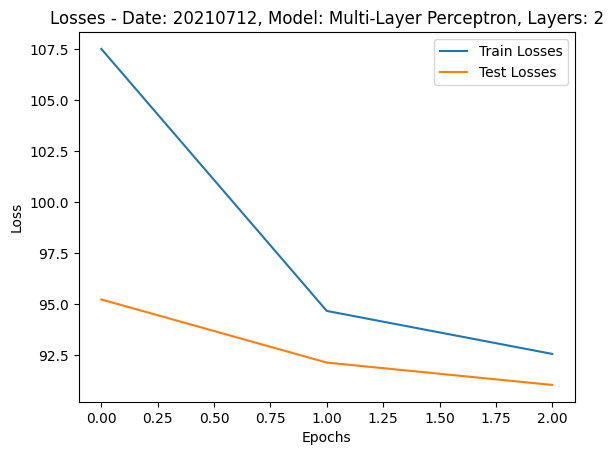

In [30]:
mlp_2layers_addedrelu = visualization.plot_losses_MLP(dataset = mlp_dataset_dict['20210712']['Joint Angles']['0']['Full'], \
                                                      train_loader = mlp_loader_dict['20210712']['Joint Angles']['0']['Train'], \
                                                      test_loader = mlp_loader_dict['20210712']['Joint Angles']['0']['Test'], \
                                                      learning_rate = 0.001, num_layers = 2, numepochs = 3, 
                                                      restraint_type = 'fullyrestrained',
                                                      add_relu = True, adapt_lr = True, save = False)

MSELoss()
Temporal CNN, full dataset
Num Conv Layers: 2, Kernel Size: 5, Total Parameters: 33503
Epoch: 000, LR: 0.001000, Train Loss: 414.387187, Test Loss: 304.923950. Train R2: -1.6280600, Test R2: -1.7072728, Train pR2: -18.2673016, Test pR2: -18.8939762
Time to train model: 1.0975241661071777


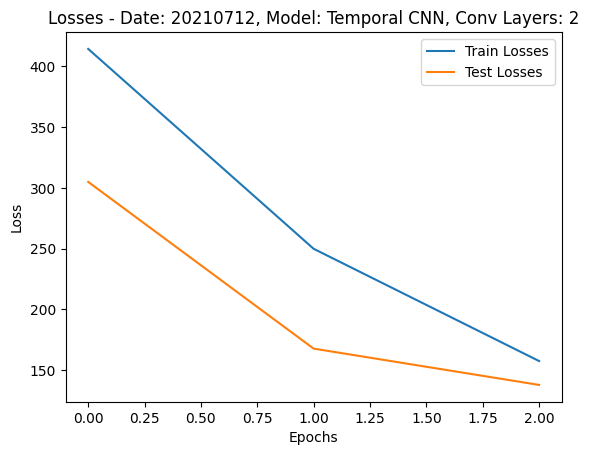

/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/Standard/NonSplit/instance_length_100/mse_loss/fullyrestrained/20210712/TempCNN_20210712_Joint Angles_2_convlayers_reluadded


In [31]:
tcn_2convlayers_addedrelu = visualization.plot_losses_TempCNN(dataset = tcn_dataset_dict['20210712']['Joint Angles']['0']['Full'],
                                                              train_loader = tcn_loader_dict['20210712']['Joint Angles']['0']['Train'],
                                                              test_loader = tcn_loader_dict['20210712']['Joint Angles']['0']['Test'],
                                                              learning_rate = 0.001, num_conv_layers = 2, numepochs = 3, 
                                                              restraint_type = 'fullyrestrained',
                                                              add_relu = True, adapt_lr = True, save = False)

# Step 5: Making Plots

Below, I'm loading several models I've already trained, along with their accompanying datasets.

In [39]:
mlp_dataset_dict_fr = data_loading.load_datasets('/content/drive/My Drive/Miller_Lab/FIU/PopFRData/processed_shuffled_opensim_datasets/fullyrestrained')
mlp_loader_dict_fr = data_loading.get_loaders(mlp_dataset_dict_fr, 32)
tcnn_dataset_dict_fr = data_loading.load_datasets('/content/drive/My Drive/Miller_Lab/FIU/PopFRData/tcnn_processed_shuffled_opensim_datasets/instance_length_100/fullyrestrained')
tcnn_loader_dict_fr = data_loading.get_loaders(tcnn_dataset_dict_fr, 32)

In [37]:
mlp_3layers_addedrelu_0309 = models.FCNet(24, mlp_dataset_dict_fr['20220309']['Joint Angles']['Full'].num_neural_units, 3, 112, add_relu = True)
mlp_3layers_addedrelu_0309.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FR_OpenSIM/NonSplit/fullyrestrained/MLP_20220309_Joint Angles_3_layers_reluadded'))
mlp_3layers_addedrelu_0712 = models.FCNet(24, mlp_dataset_dict_fr['20210712']['Joint Angles']['Full'].num_neural_units, 3, 112, add_relu = True)
mlp_3layers_addedrelu_0712.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FR_OpenSIM/NonSplit/fullyrestrained/MLP_20210712_Joint Angles_3_layers_reluadded'))
mlp_3layers_addedrelu_1105 = models.FCNet(24, mlp_dataset_dict_fr['20211105']['Joint Angles']['Full'].num_neural_units, 3, 112, add_relu = True)
mlp_3layers_addedrelu_1105.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FR_OpenSIM/NonSplit/fullyrestrained/MLP_20211105_Joint Angles_3_layers_reluadded'))
mlp_3layers_addedrelu_0710 = models.FCNet(24, mlp_dataset_dict_fr['20210710']['Joint Angles']['Full'].num_neural_units, 3, 112, add_relu = True)
mlp_3layers_addedrelu_0710.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FR_OpenSIM/NonSplit/fullyrestrained/MLP_20210710_Joint Angles_3_layers_reluadded'))
mlp_3layers_addedrelu_0814 = models.FCNet(24, mlp_dataset_dict_fr['20210814']['Joint Angles']['Full'].num_neural_units, 3, 112, add_relu = True)
mlp_3layers_addedrelu_0814.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/MLP/Pop_FR_OpenSIM/NonSplit/fullyrestrained/MLP_20210814_Joint Angles_3_layers_reluadded'))

cnn_4convlayers_add_relu_0309 = models.TempConvNet(24, tcnn_dataset_dict_fr['20220309']['Joint Angles']['Full'].num_neural_units, 4, 1, 5, 2, add_relu = True, causal=False)
cnn_4convlayers_add_relu_0309.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/Standard/NonSplit/instance_length_100/fullyrestrained/r2loss/TempCNN_20220309_Joint Angles_4_convlayers_reluadded'))
cnn_4convlayers_add_relu_0712 = models.TempConvNet(24, tcnn_dataset_dict_fr['20210712']['Joint Angles']['Full'].num_neural_units, 4, 1, 5, 2, add_relu = True, causal=False)
cnn_4convlayers_add_relu_0712.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/Standard/NonSplit/instance_length_100/fullyrestrained/r2loss/TempCNN_20210712_Joint Angles_4_convlayers_reluadded'))
cnn_4convlayers_add_relu_1105 = models.TempConvNet(24, tcnn_dataset_dict_fr['20211105']['Joint Angles']['Full'].num_neural_units, 4, 1, 5, 2, add_relu = True, causal=True)
cnn_4convlayers_add_relu_1105.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/Standard/NonSplit/instance_length_100/fullyrestrained/r2loss/TempCNN_20211105_Joint Angles_4_convlayers_reluadded'))
cnn_4convlayers_add_relu_0710 = models.TempConvNet(24, tcnn_dataset_dict_fr['20210710']['Joint Angles']['Full'].num_neural_units, 4, 1, 5, 2, add_relu = True, causal=True)
cnn_4convlayers_add_relu_0710.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/Standard/NonSplit/instance_length_100/fullyrestrained/r2loss/TempCNN_20210710_Joint Angles_4_convlayers_reluadded'))
cnn_4convlayers_add_relu_0814 = models.TempConvNet(24, tcnn_dataset_dict_fr['20210814']['Joint Angles']['Full'].num_neural_units, 4, 1, 5, 2, add_relu = True, causal=True)
cnn_4convlayers_add_relu_0814.load_state_dict(torch.load('/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/Standard/NonSplit/instance_length_100/fullyrestrained/r2loss/TempCNN_20210814_Joint Angles_4_convlayers_reluadded'))

<All keys matched successfully>

In [48]:
mlp_models_dict = {'20220309':mlp_3layers_addedrelu_0309,
                        '20210712':mlp_3layers_addedrelu_0712,
                        '20211105':mlp_3layers_addedrelu_1105,
                        '20210710':mlp_3layers_addedrelu_0710,
                        '20210814':mlp_3layers_addedrelu_0814,}

tcn_models_dict = {'20220309':cnn_4convlayers_add_relu_0309,
                      '20210712':cnn_4convlayers_add_relu_0712,
                      '20211105':cnn_4convlayers_add_relu_1105,
                      '20210710':cnn_4convlayers_add_relu_0710,
                      '20210814':cnn_4convlayers_add_relu_0814,}

You can obtain the pr2 values for a model using the get_all_pr2 function in the r2_pr2 module. Make sure to use the associated loader/dataset. Note that since I'm using the test dataloader, it will return pr2 values for the test set.

Using the plot_distributions function in the visualization model , you can plot the distribution of the predictions over the real targets for each electrode. By default, it plots 106 electrodes in a 12x8 grid, but this can be easily changed to accommodate more electrodes if you'd like. Again, these distributions are for the test set.

I do the above for a MLP and TCN trained on the 20210712 dataset.

In [60]:
model = mlp_3layers_addedrelu_0712
full_dataset = mlp_dataset_dict_fr['20210712']['Joint Angles']['Full']
test_loader = mlp_loader_dict_fr['20210712']['Joint Angles']['Test']
pr2_by_neuron_mlp_0712 = r2_pr2.get_all_pr2(model, full_dataset, test_loader, conv = False)

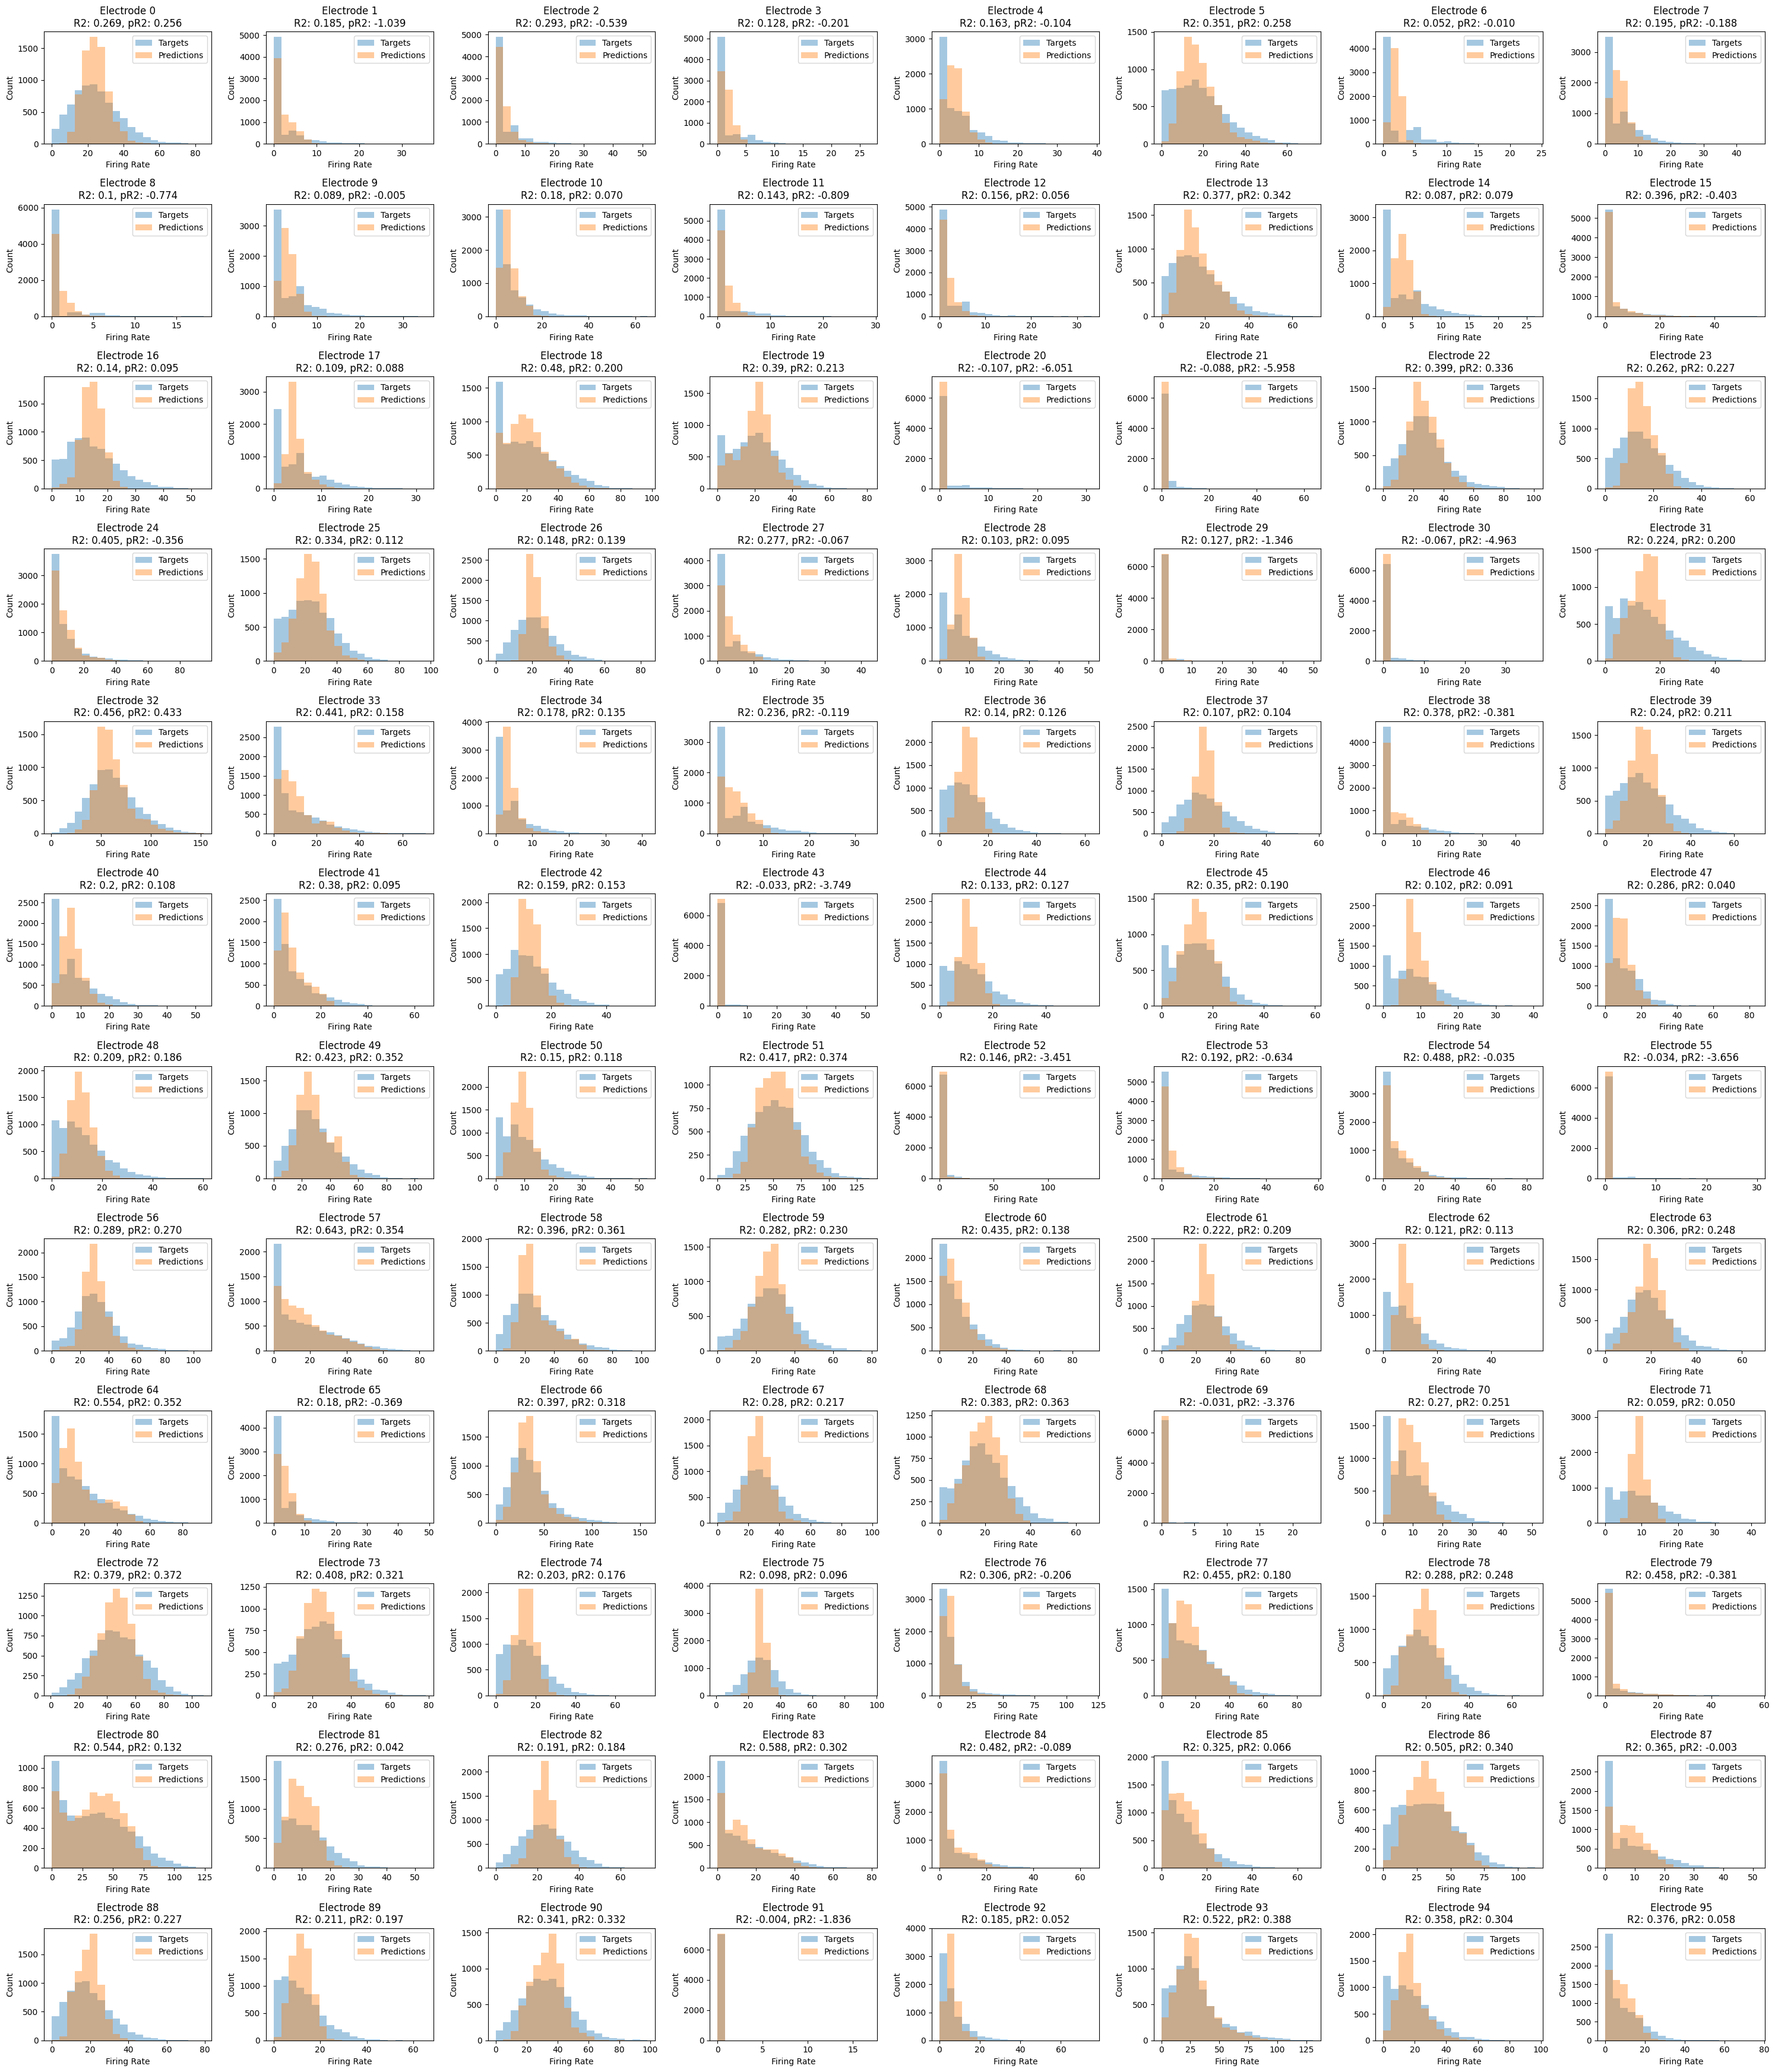

In [61]:
test_target_dist_lst_0712, test_pred_dist_lst_0712 = visualization.plot_distributions(model,full_dataset,test_loader,conv=False)

In [63]:
model = cnn_4convlayers_add_relu_0712
full_dataset = tcnn_dataset_dict_fr['20210712']['Joint Angles']['Full']
test_loader = tcnn_loader_dict_fr['20210712']['Joint Angles']['Test']
pr2_by_neuron_tcn_0712 = r2_pr2.get_all_pr2(model, full_dataset, test_loader, conv = True)

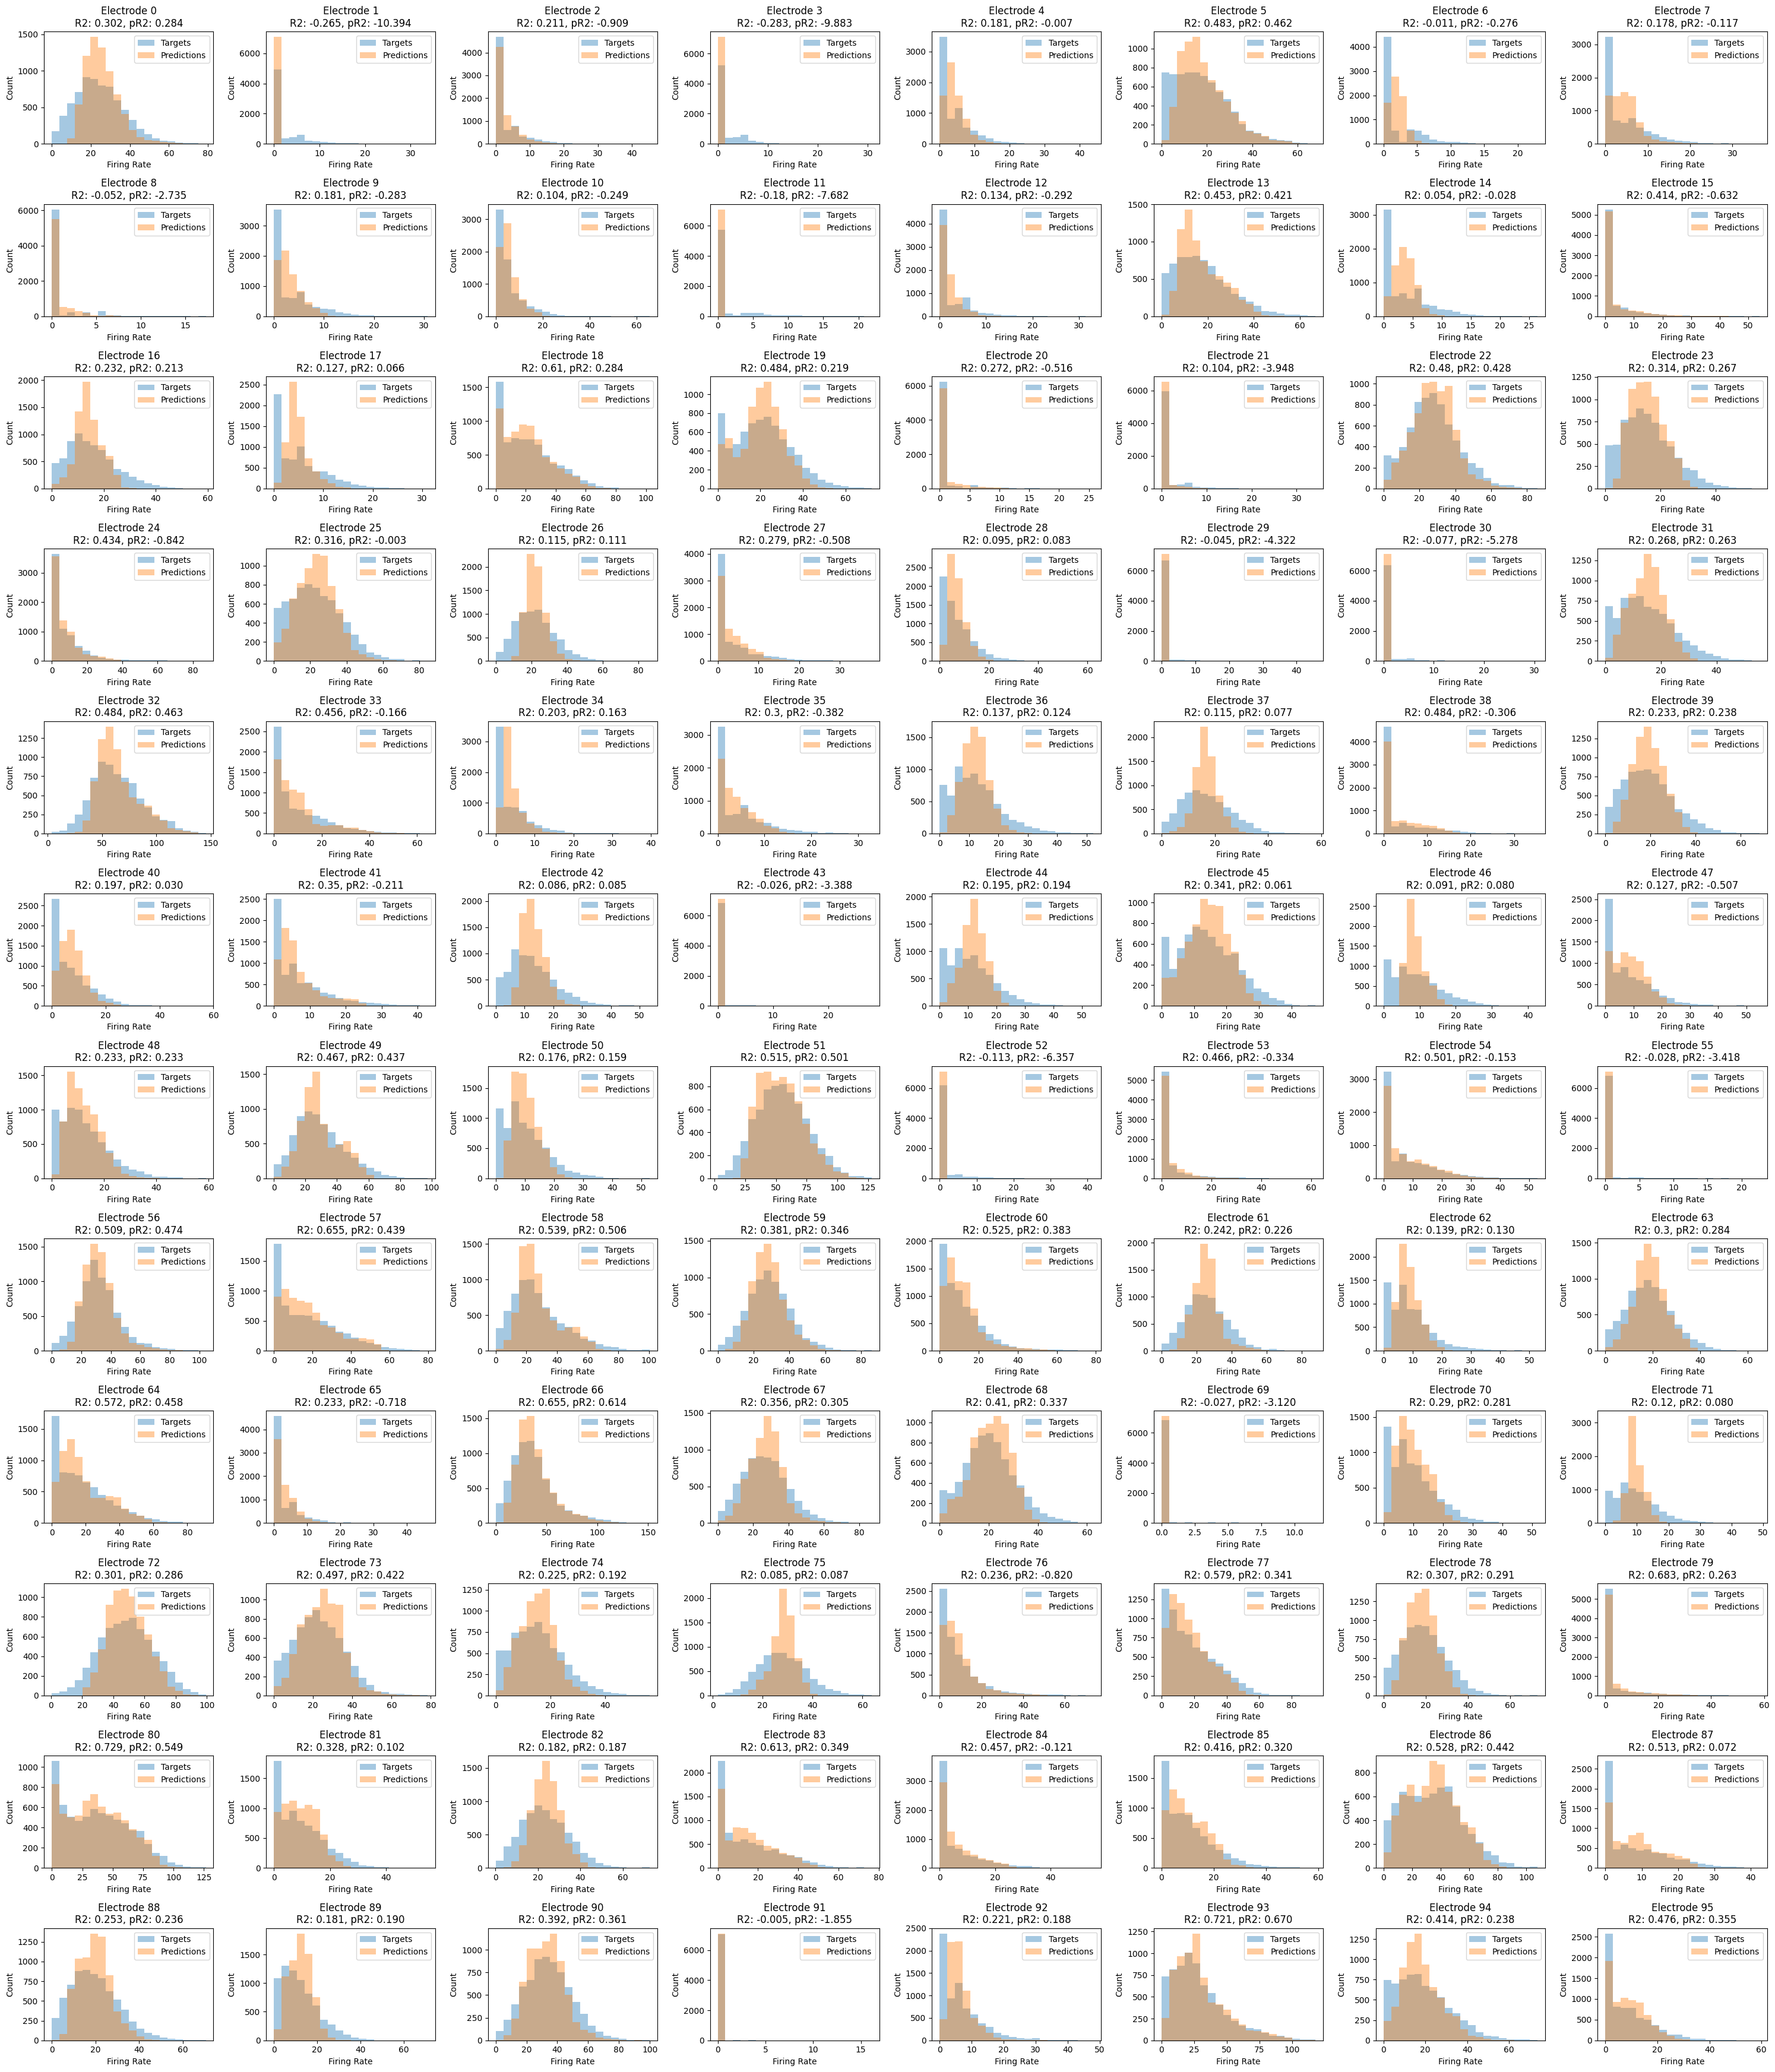

In [64]:
test_target_dist_lst_tcn_0712, test_pred_dist_lst_tcn_0712 = visualization.plot_distributions(model,full_dataset,test_loader,conv=True)

Below, I find the electrodes where performance for either one or both of the models is bad. 

In [65]:
dates_list = ['20210712']
pr2_by_neuron_mlp = [pr2_by_neuron_mlp_0712]
pr2_by_neuron_tcn = [pr2_by_neuron_tcn_0712]

both_bad = {}
mlp_worse = {}
tcn_worse = {}

for date, mlp_pr2_arr, tcn_pr2_arr in zip(dates_list, pr2_by_neuron_mlp,pr2_by_neuron_tcn):
    print(date)
    
    both_bad[date] = []
    mlp_worse[date] = []
    tcn_worse[date] = []

    print('{}: Electrodes with big difference'.format(date))
    for i, (mlp_pr2, tcn_pr2) in enumerate(zip(mlp_pr2_arr, tcn_pr2_arr)):
        if (((abs(mlp_pr2-tcn_pr2)>0.2) and (tcn_pr2*mlp_pr2<0))) or (abs(mlp_pr2-tcn_pr2)>1.0):
            if (mlp_pr2>tcn_pr2):
                s = ' TCN did worse'
                tcn_worse[date].append(i)
            else:
                s = ' MLP did worse'
                mlp_worse[date].append(i)
            print(('Electrode: {}, MLP pR2: {}, TCN pR2: {}.'+s).format(i,mlp_pr2,tcn_pr2))
    print('{}: Electrodes where both models performed poorly'.format(date))
    for i, (mlp_pr2, tcn_pr2) in enumerate(zip(mlp_pr2_arr, tcn_pr2_arr)):
        if ((mlp_pr2<0) and (tcn_pr2<0) and (abs(mlp_pr2-tcn_pr2)<1.0)):
            print('Electrode: {}, MLP pR2: {}, TCN pR2: {}'.format(i,mlp_pr2,tcn_pr2))
            both_bad[date].append(i)
    print('\n')

20210712
20210712: Electrodes with big difference
Electrode: 1, MLP pR2: -1.0389773845672607, TCN pR2: -10.393933296203613. TCN did worse
Electrode: 3, MLP pR2: -0.20139575004577637, TCN pR2: -9.883208274841309. TCN did worse
Electrode: 8, MLP pR2: -0.7738949060440063, TCN pR2: -2.735288619995117. TCN did worse
Electrode: 10, MLP pR2: 0.06984817981719971, TCN pR2: -0.24936270713806152. TCN did worse
Electrode: 11, MLP pR2: -0.8094102144241333, TCN pR2: -7.681726455688477. TCN did worse
Electrode: 12, MLP pR2: 0.0562627911567688, TCN pR2: -0.29171836376190186. TCN did worse
Electrode: 20, MLP pR2: -6.051467418670654, TCN pR2: -0.5159354209899902. MLP did worse
Electrode: 21, MLP pR2: -5.958465576171875, TCN pR2: -3.947869300842285. MLP did worse
Electrode: 29, MLP pR2: -1.3459017276763916, TCN pR2: -4.322378635406494. TCN did worse
Electrode: 33, MLP pR2: 0.15848857164382935, TCN pR2: -0.1657881736755371. TCN did worse
Electrode: 41, MLP pR2: 0.0948324203491211, TCN pR2: -0.210900664329

Using the plot_compare_distributions_subset function in the visualization module, you can compare distributions of predictions of two models side by side for a subset of electrodes. Here, I've plotted the distributions for the MLP and the TCN for the electrodes where the TCN performed significantly worse than the MLP on their respective test sets. Note that while the distributions of the targets are similar, they are not exactly the same, as the TCN and MLP datasets were created separately, and won't have exactly the same instances. That being said, their distributions are nonetheless very similar.

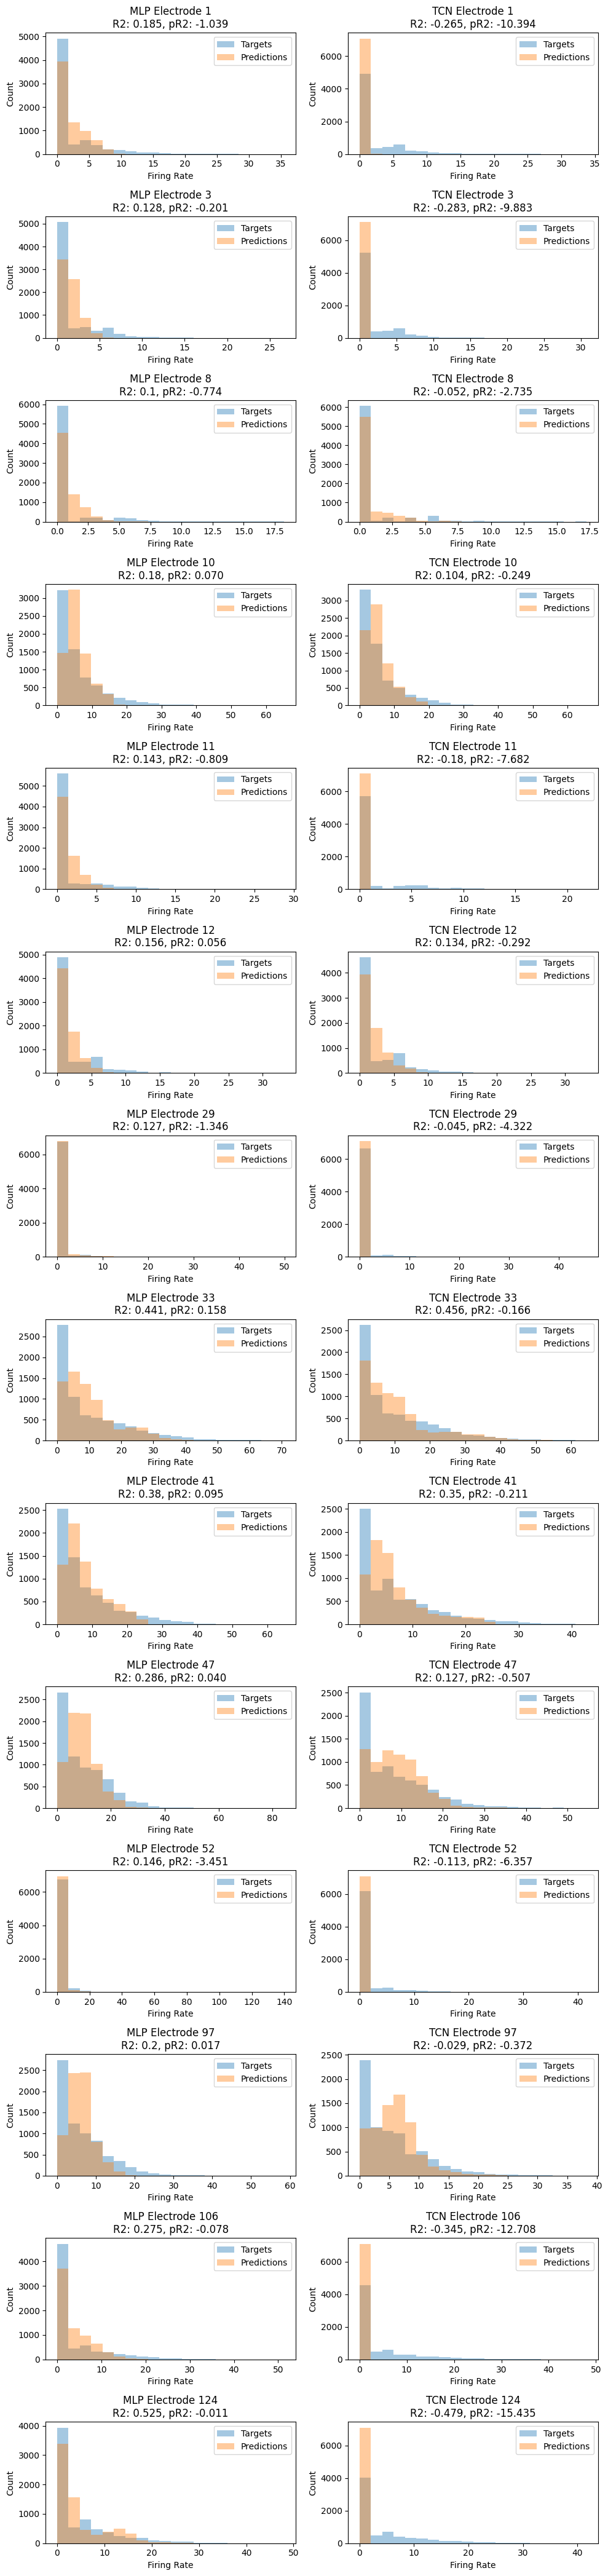

In [66]:
visualization.plot_compare_distributions_subset(mlp_models_dict['20210712'], 
                                             mlp_dataset_dict_fr['20210712']['Joint Angles']['Full'], 
                                             mlp_loader_dict_fr['20210712']['Joint Angles']['Test'], 
                                             tcn_models_dict['20210712'], 
                                             tcnn_dataset_dict_fr['20210712']['Joint Angles']['Full'], 
                                             tcnn_loader_dict_fr['20210712']['Joint Angles']['Test'], 
                                             tcn_worse['20210712'])

Using the plot_targets_and_preds_agnostic function in the visualization module, you can plot the predictions of a model for any specified range of the dataset. Here, I plot the predictions of the MLP and TCN vs the real targets for the 20s contiguous interval where the monkey is doing something interesting - these values are stored in the good_inputs_dict and good_frates_dict we defined above. 

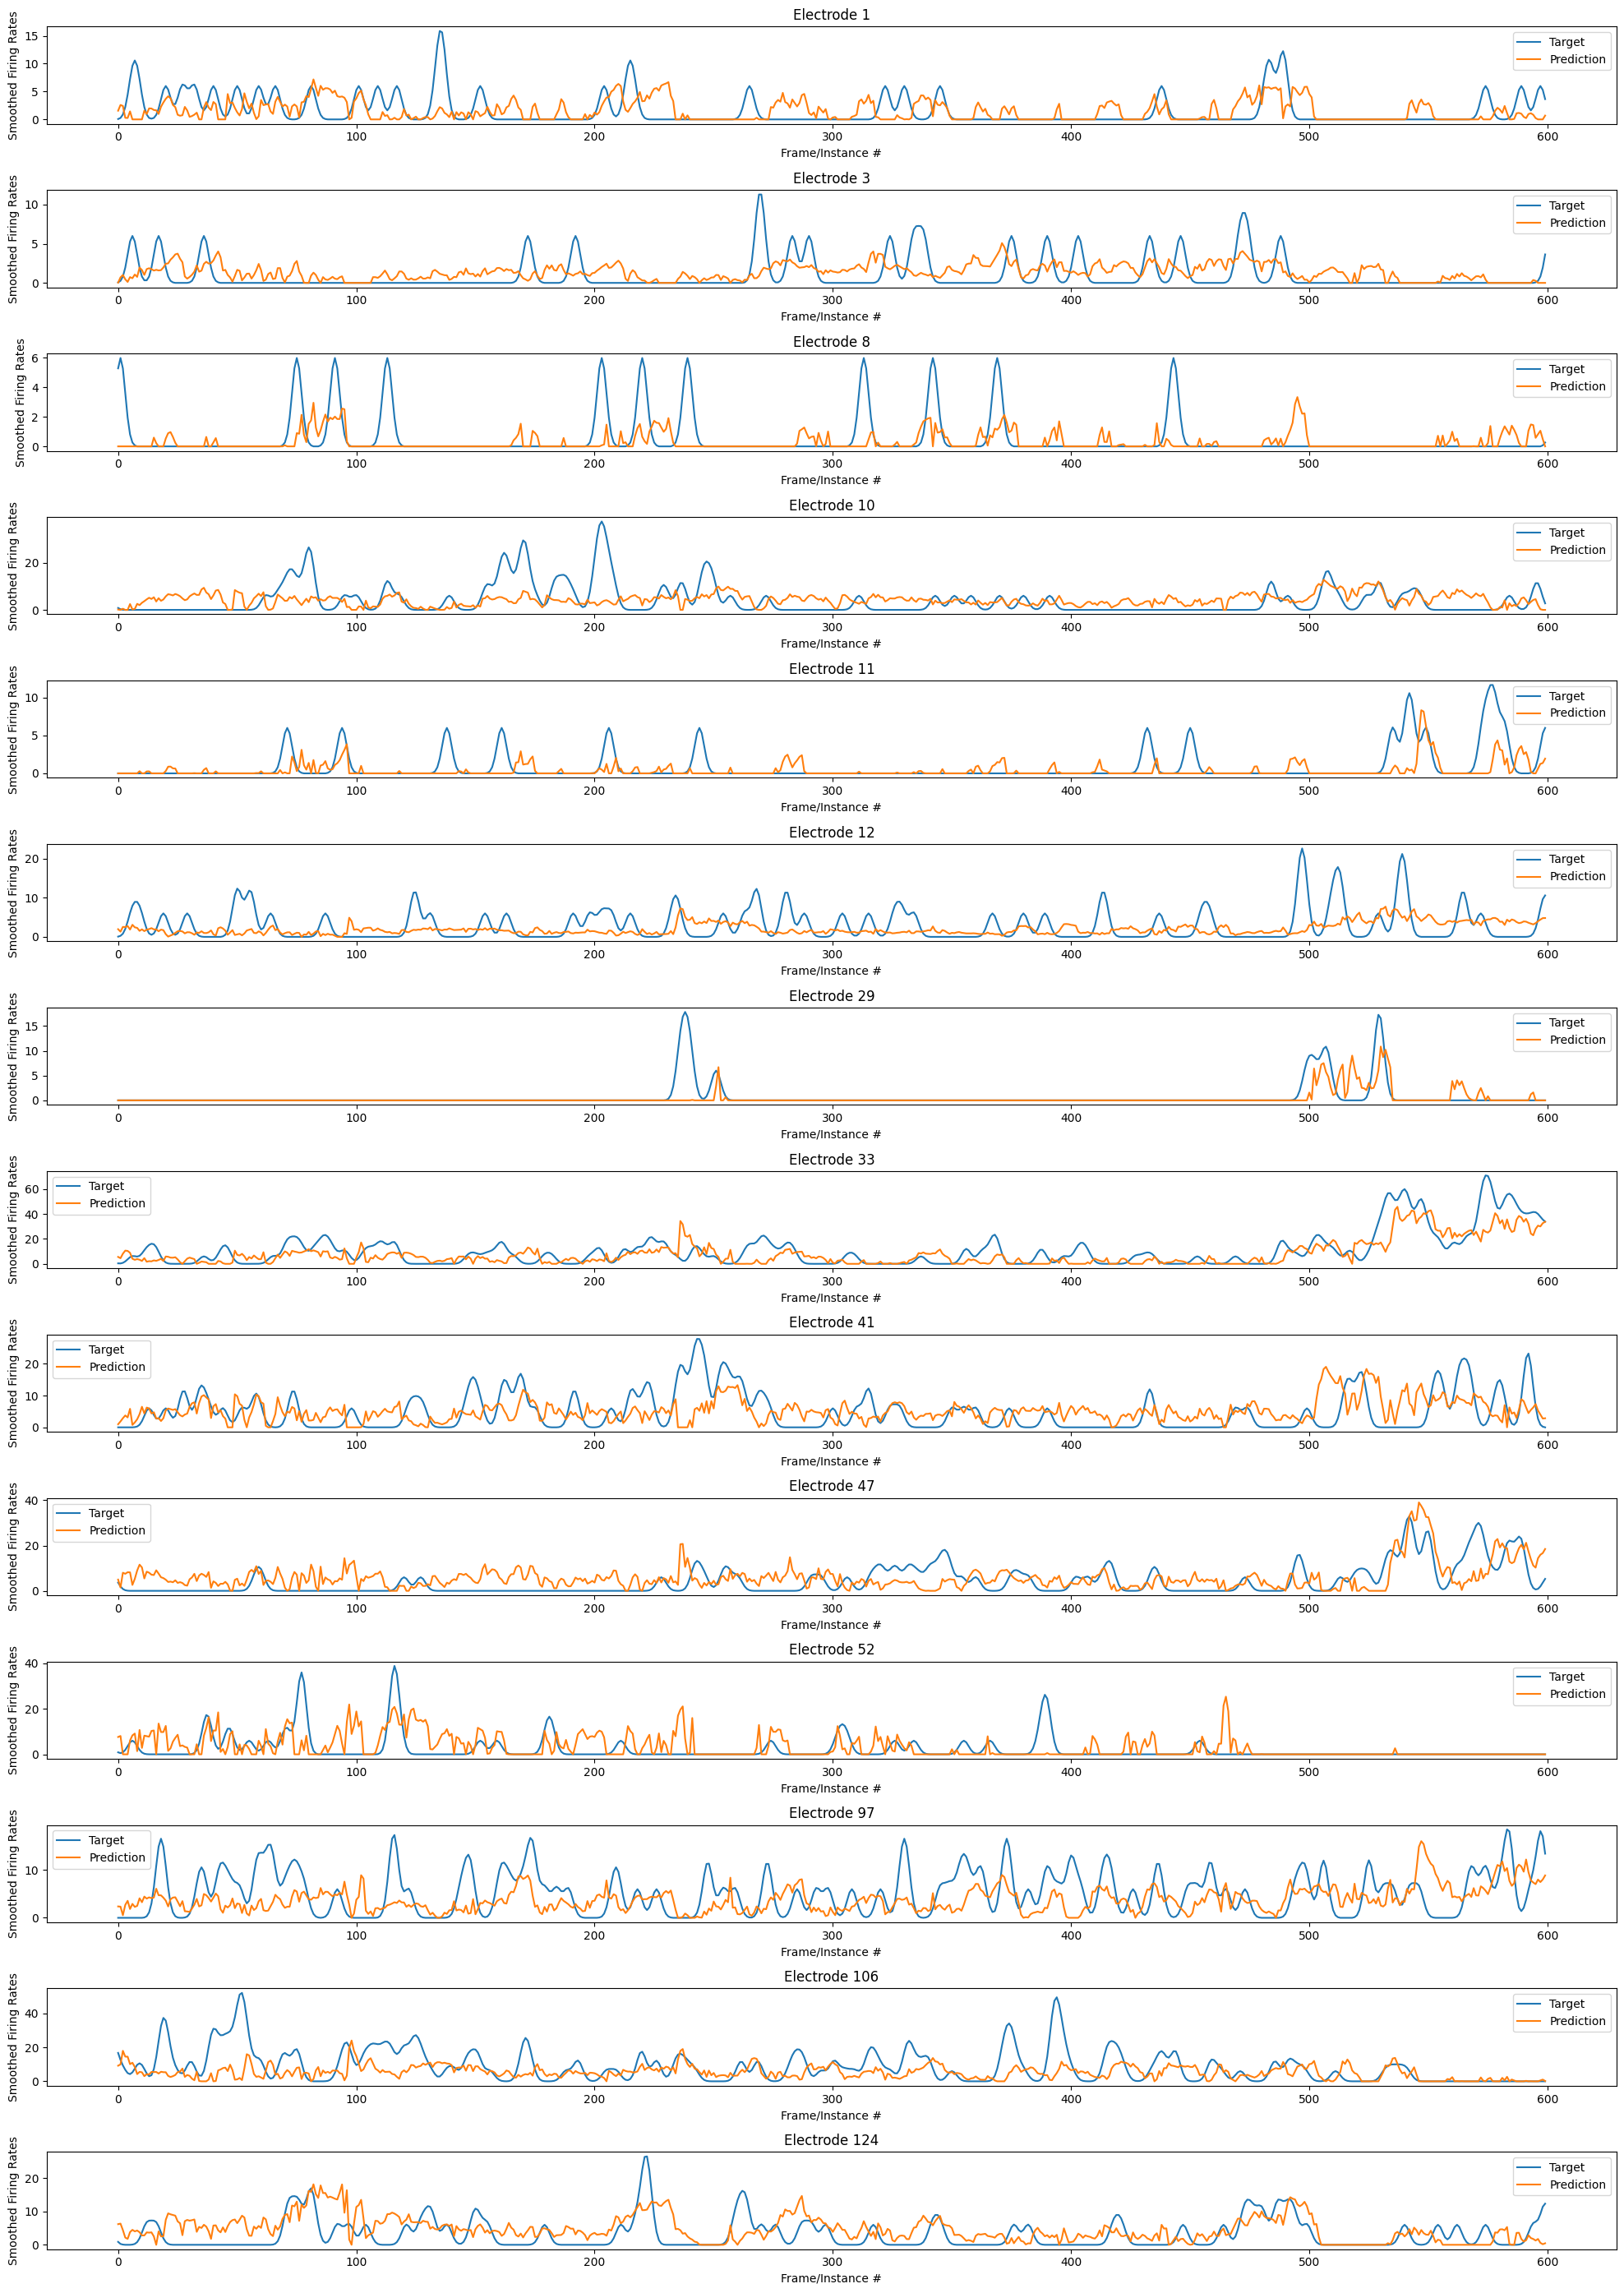

In [76]:
#MLP
visualization.plot_targets_and_preds_agnostic(mlp_models_dict['20210712'], 
                                              good_inputs_dict['20210712'], 
                                              good_frates_dict['20210712'], 
                                              tcn_worse['20210712'], False)

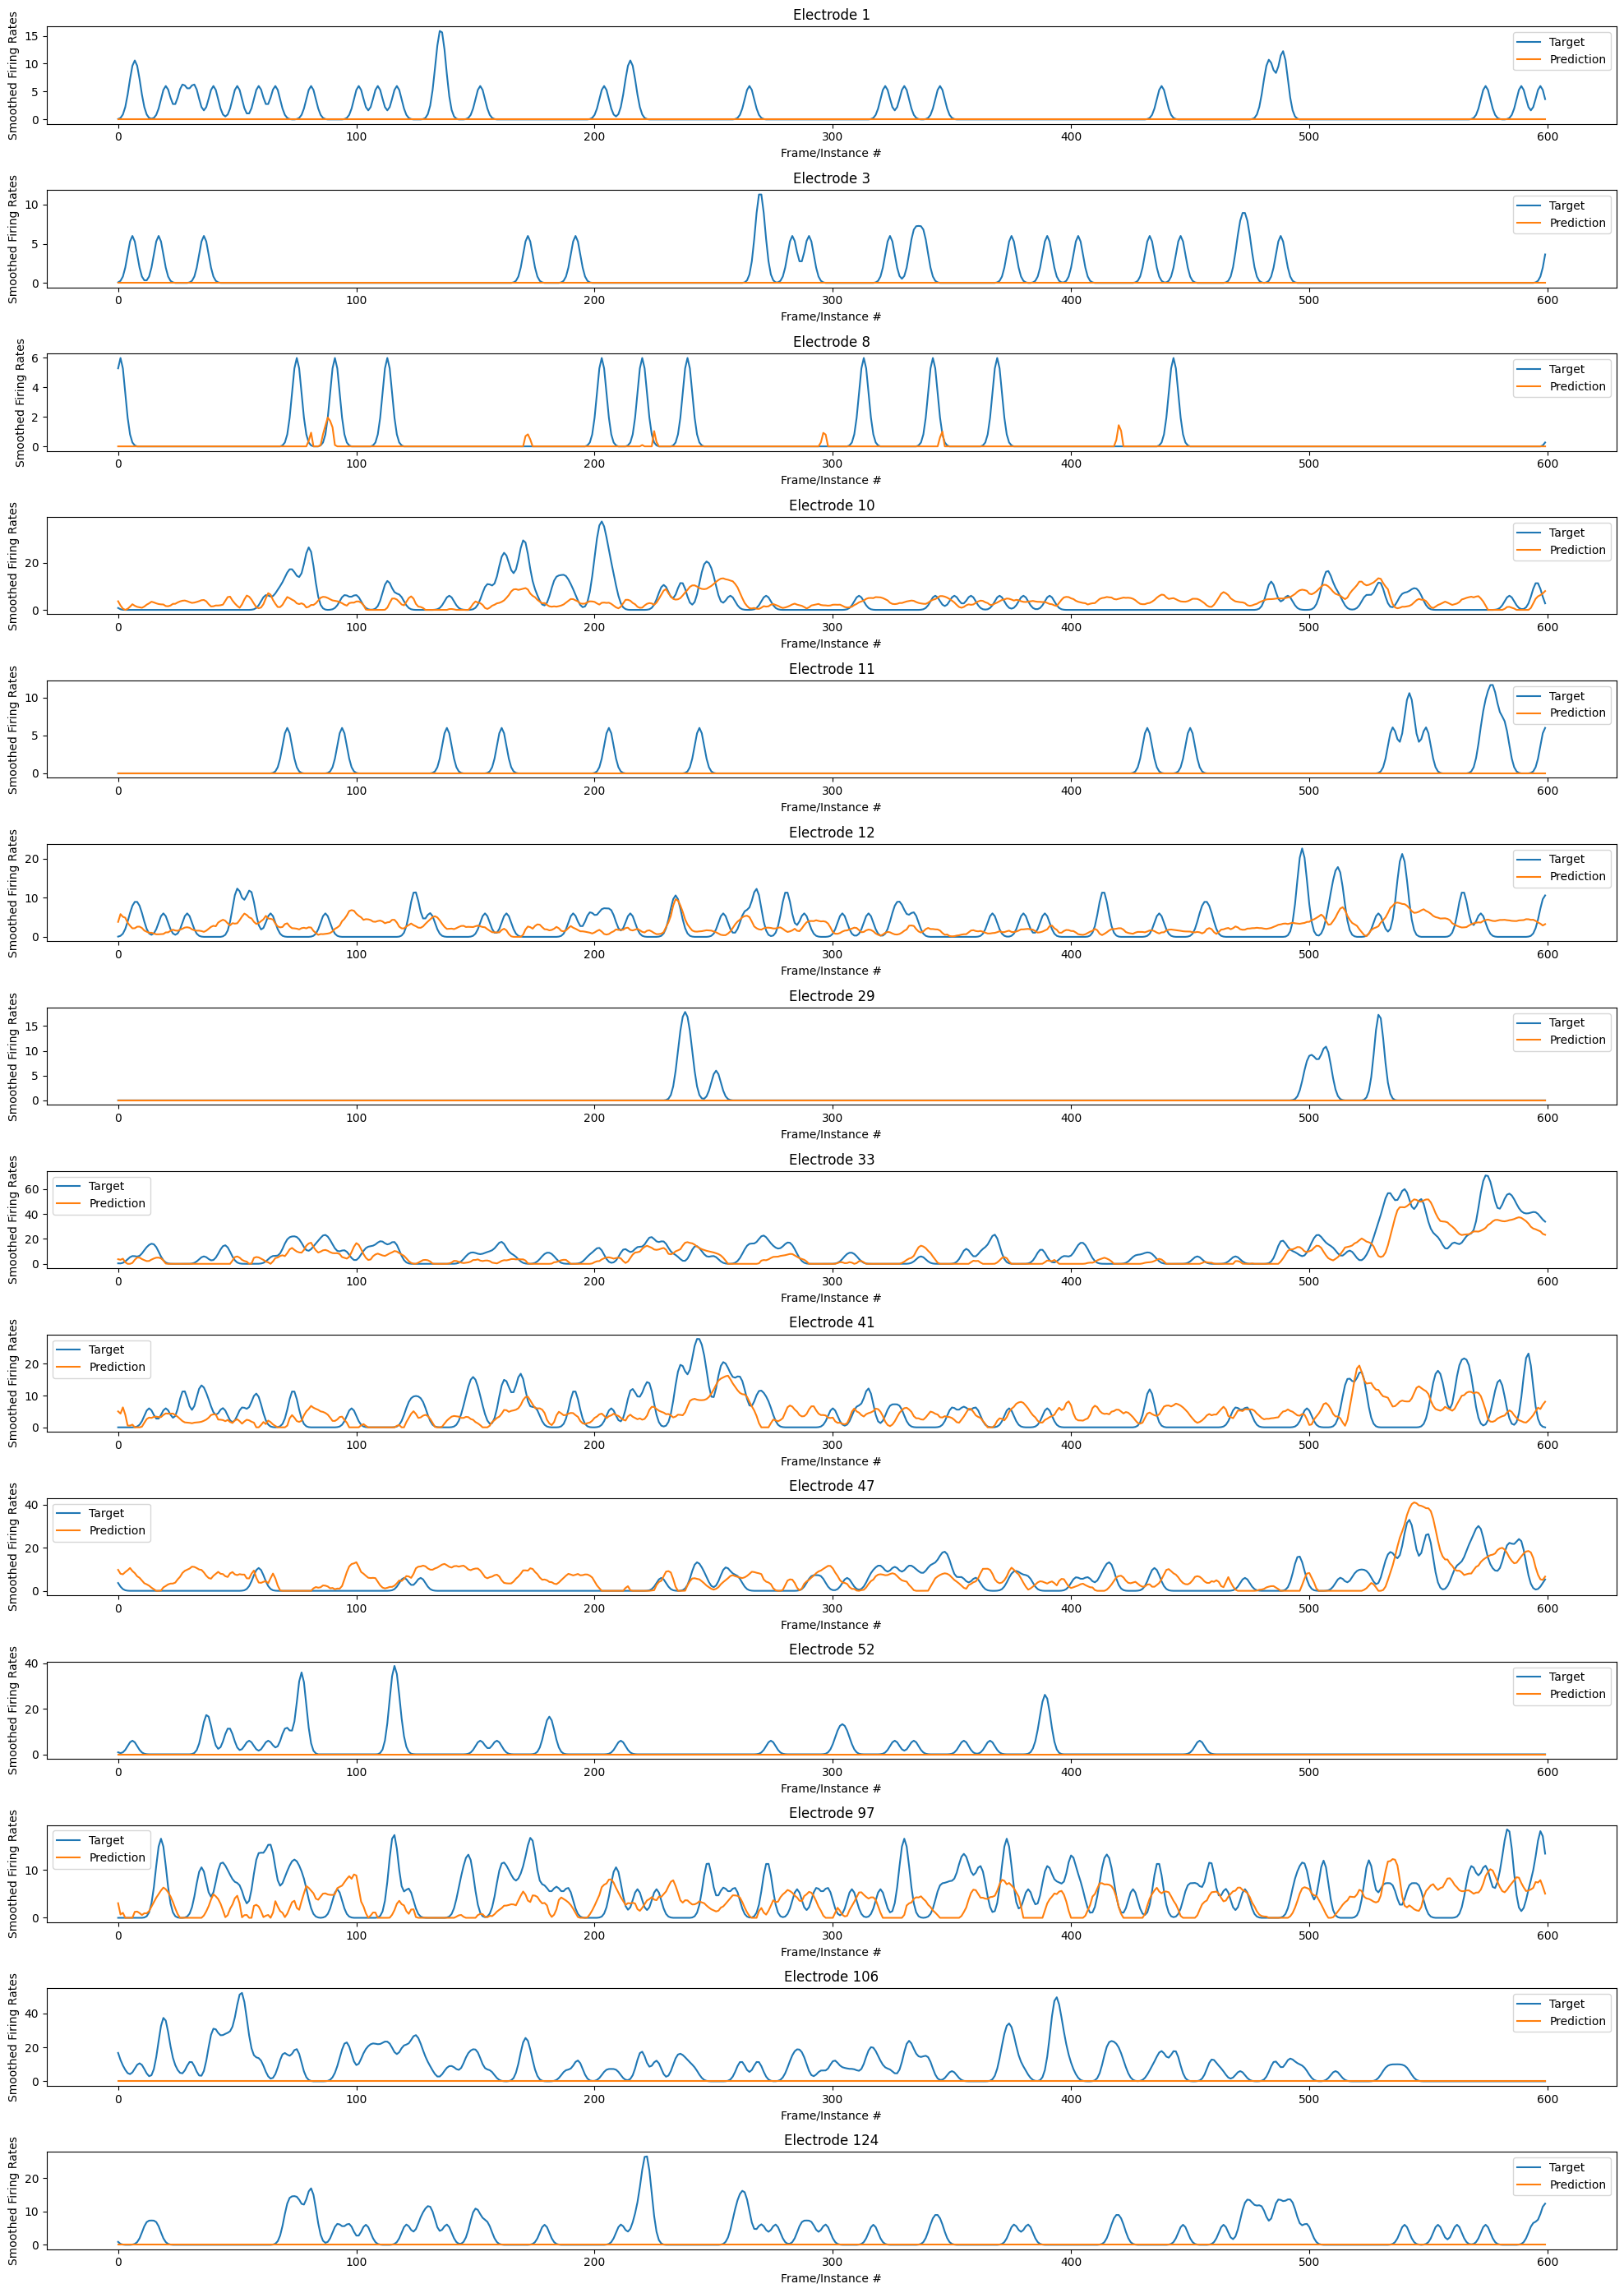

In [77]:
#TCN
visualization.plot_targets_and_preds_agnostic(tcn_models_dict['20210712'], 
                                              good_inputs_dict['20210712'], 
                                              good_frates_dict['20210712'], 
                                              tcn_worse['20210712'], True)

Using the compare_pr2_plots function in the visualization module, you can compare the performance of two models by electrode. Each dot on the scatterplot generated represents a single electrode, and the color of that dot represents the electrode's depth of modulation. You can exclude "bad" electrodes by changing the value of exclude_bad_neurons. Note that the bright yellow dot in the bottom right corner of the second plot is not a real electrode - that is only there to standardize the color bar.

TCN average pR2: -0.5316894054412842
MLP average pR2: -0.18218795955181122


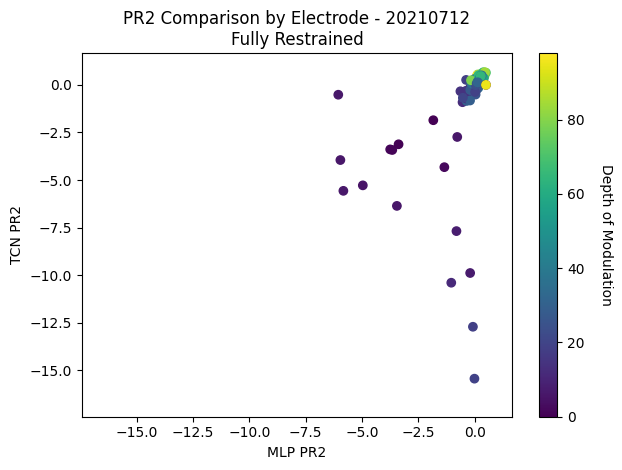

In [92]:
model_1_name = 'TCN'
model1 = tcn_models_dict['20210712']
dataset1 = tcnn_dataset_dict_fr['20210712']['Joint Angles']['Full']
test_loader1 = tcnn_loader_dict_fr['20210712']['Joint Angles']['Test']
conv1 = True
model_2_name = 'MLP'
model2 = mlp_models_dict['20210712']
dataset2 = mlp_dataset_dict_fr['20210712']['Joint Angles']['Full']
test_loader2 = mlp_loader_dict_fr['20210712']['Joint Angles']['Test']
conv2 = False
restraint_type = 'Fully Restrained'

visualization.compare_pr2_plots(model_1_name, model1, dataset1, test_loader1, conv1, 
                  model_2_name, model2, dataset2, test_loader2, conv2, 
                  restraint_type, exclude_bad_neurons = False, max_dom = 95)

TCN average pR2: -0.5316894054412842
MLP average pR2: -0.18218795955181122


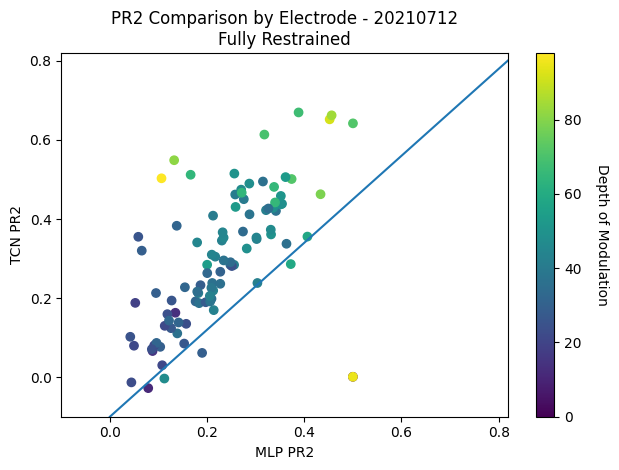

In [93]:
visualization.compare_pr2_plots(model_1_name, model1, dataset1, test_loader1, conv1, 
                                model_2_name, model2, dataset2, test_loader2, conv2, 
                                restraint_type, exclude_bad_neurons = True, max_dom = 95)

Using the plot_and_compare_ks function in the visualization module, you can plot the distributions of the KS statistic for the predictions for two models. The blue and orange vertical lines represent the mean of the blue and orange distributions, respectively.

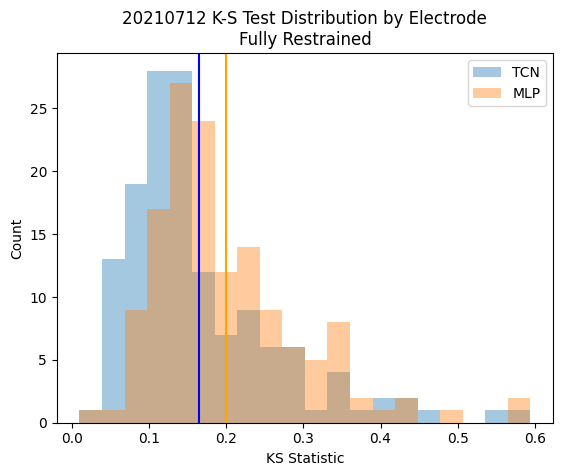

(0.16511406466970838, 0.19929258900874858)

In [101]:
visualization.plot_and_compare_ks(model_1_name, model1, dataset1, test_loader1, conv1, 
                                  model_2_name, model2, dataset2, test_loader2, conv2, 
                                  restraint_type, bins = 20)

# Side Notes: Transfer Learning

I never used a single main function to perform transfer learning - I felt like there were too many bells and whistles to create a single function. However, I've created an example of a transfer learning function for a TCN that can be used on a set of datasets that have been split by neuron.

In [102]:
tcnn_dataset_dict_split = data_loading.load_datasets('/content/drive/My Drive/Miller_Lab/FIU/PopFRData/tcnn_processed_shuffled_opensim_datasets_splitneurons/instance_length_100/fullyrestrained/',split_neurons = True)
tcnn_loader_dict_split = data_loading.get_loaders(tcnn_dataset_dict_split, 32,split_neurons = True)

20220309 0
20220309 0 Linear(in_features=192, out_features=32, bias=True) 32
Date: 20220309, Split: 0, Initial LR: 0.001 
Num Conv Layers: 3, Total Parameters: 127472
Epoch: 000, LR: 0.001000, Train Loss: 405.211115, Test Loss: 253.740318. Train R2: -1.8495418, Test R2: -1.7650056, Train pR2: -22.1028366, Test pR2: -21.8615379
Epoch: 050, LR: 0.001000, Train Loss: 58.195122, Test Loss: 62.501057. Train R2: 0.4026787, Test R2: 0.3183570, Train pR2: -0.3565080, Test pR2: -0.4511971
Epoch: 100, LR: 0.000328, Train Loss: 53.610849, Test Loss: 60.696302. Train R2: 0.4498711, Test R2: 0.3428828, Train pR2: -0.3294640, Test pR2: -0.4384846
Time to train model: 26.82837462425232


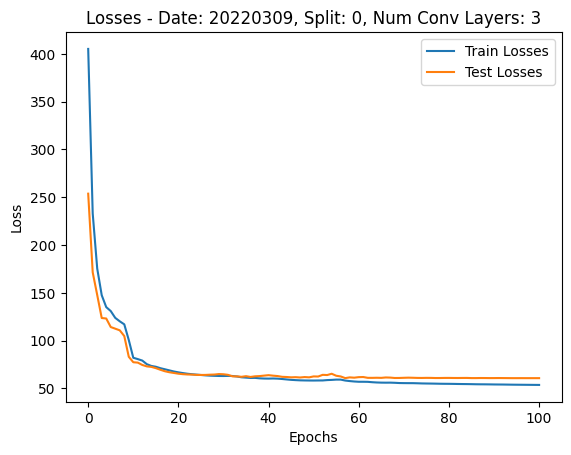

20210712 0
20210712 0 Linear(in_features=192, out_features=47, bias=True) 47
Date: 20210712, Split: 0, Initial LR: 0.001 
Num Conv Layers: 3, Total Parameters: 130367
Epoch: 000, LR: 0.001000, Train Loss: 252.369612, Test Loss: 160.077245. Train R2: -0.3820922, Test R2: -0.3727619, Train pR2: -5.9039435, Test pR2: -5.8259149


KeyboardInterrupt: ignored

In [116]:
visualization.plot_losses_transfer_learning_TCN(tcnn_dataset_dict_split, tcnn_loader_dict_split, 18, 0.001, 0.7)